# Models <br>

In this notebook I create and evaluate the final models (regression AND classifier). The following steps are executed: <br>

1. **Selecting features:** With over more than 80 features I want to select the subset of features that is most powerful in predicting y.
2. **Parameter tuning:** I want to find the best possible set of parameters for my model.
3. **Cross Validation:** For both (1) and (2) CV methods with 5-folds are used. This way the model is protected against overfitting, and I get a more robust score.
4. **Evaluating:** How successful are the models in predicting y?

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV

import sklearn.metrics as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
plt.rcParams.update({'font.size': 22})

In [3]:
import import_ipynb
import modelling_preperation

importing Jupyter notebook from modelling_preperation.ipynb


## Create Train and Test set

In [4]:
# Import features dataframe
df = pd.read_pickle("data/data_features")

In [5]:
# These are the conditions by which we label the different classes
conditions_3_classes = [
    (df['T3F_54'] < 5),
    (df['T3F_54'] >= 5) & (df['T3F_54'] < 10),
    (df['T3F_54'] >= 10)
    ]

conditions_5_classes = [
    (df['T3F_54'] < 3),
    (df['T3F_54'] >= 3) & (df['T3F_54'] < 6),
    (df['T3F_54'] >= 6) & (df['T3F_54'] < 9),
    (df['T3F_54'] >= 9) & (df['T3F_54'] < 12),
    (df['T3F_54'] >= 12)
    ]

# create a new column and use np.select to assign values to it using our lists as arguments
df['label_3_classes'] = np.select(conditions_3_classes, [1, 2, 3])
df['label_5_classes'] = np.select(conditions_5_classes, [1, 2, 3, 4, 5])

In [6]:
# Create train-test split
# These sets are already decomposed and scaled

# ONLY DO THIS ONCE!

X_train, X_test, y_train, y_test, feature_names = modelling_preperation.create_train_test_set(df)

In [7]:
# ONLY DO THIS ONCE!

# Save the train test split, so I use the same set for all the different model
np.savetxt('data/train_test/x_train.csv', X_train, delimiter=',')
np.savetxt('data/train_test/x_test.csv', X_test, delimiter=',')
y_train.to_pickle('data/train_test/y_train')
y_test.to_pickle('data/train_test/y_test')

with open("data/train_test/feature_names.txt", "wb") as fp:
    pickle.dump(feature_names, fp)

In [2]:
# Load the train test split
X_train = np.loadtxt('data/train_test/x_train.csv', delimiter=',')
X_test = np.loadtxt('data/train_test/x_test.csv', delimiter=',')
y_train = pd.read_pickle("data/train_test/y_train")
y_test = pd.read_pickle("data/train_test/y_test")

with open("data/train_test/feature_names.txt", "rb") as fp:
    feature_names = pickle.load(fp)

col = np.array(feature_names)

# Classifier (Fail-Pass)

I have tried different classification estimators. The RandomForestClassifier has the best results. It also has the attribute feature_importances_ which can give us insights in which features are important.

## Parameter
I define a set of paramaters to try out. Random sets of these parameters are tried out by the RandomizedSearchCV. The combination of parameters that results in the highest score are then picked.

In [3]:
param_grid = {
    'max_depth': [1, 5, 10, 15, 20],
    'n_estimators': [5, 10, 100],
    'random_state': [1, 5, 10, 15, 20, 25],
}

## Pipeline
The pipeline consists of two stages. First, the best set of features is selected. Then, the best set of parameters is selected. Both through cross validation.

In [4]:
classifier_pipeline = Pipeline([
        ('feature_selection', RFECV(RandomForestClassifier(), scoring='roc_auc')),
        ('parameter_tuning', RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='roc_auc'))          
    ])

## Train model and predict test set
I fit the pipeline on the train set, after which I predict the y values of the test set.

In [123]:
classifier_pipeline.fit(X_train, y_train['label'])

Pipeline(steps=[('feature_selection',
                 RFECV(estimator=RandomForestClassifier(), scoring='roc_auc')),
                ('parameter_tuning',
                 RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                                    param_distributions={'max_depth': [1, 5, 10,
                                                                       15, 20],
                                                         'n_estimators': [5, 10,
                                                                          100],
                                                         'random_state': [1, 5,
                                                                          10,
                                                                          15,
                                                                          20,
                                                                          25]},
                                    scoring='roc_au

In [124]:
# Calculate y and its probabilities
classifier_y_test_pred = classifier_pipeline.predict(X_test)

In [125]:
# These are the best parameters found by the RandomizedSearchCV
print(classifier_pipeline['parameter_tuning'].best_params_)

{'random_state': 25, 'n_estimators': 100, 'max_depth': 5}


In [143]:
# Save model
classifier = classifier_pipeline['parameter_tuning'].best_estimator_
pickle.dump(classifier, open("models/classifier", 'wb'))

In [2]:
classifier = pickle.load(open("models/classifier", 'rb'))

## Evaluate model


In [3]:
def classifier_evaluation_report(pipeline, X_test, y_test, y_test_pred, labels):
    # Plot confustion matrix
    sm.plot_confusion_matrix(pipeline, X_test, y_test, display_labels=labels, cmap=plt.cm.Blues)
    plt.grid(False)

    # Plot ROC Curve
    sm.plot_roc_curve(pipeline, X_test, y_test)
    plt.show()

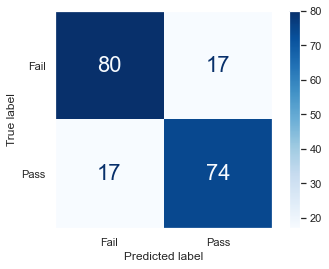

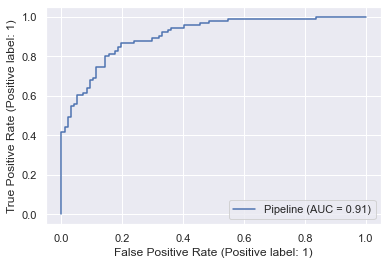

In [127]:
classifier_evaluation_report(classifier_pipeline, X_test, y_test['label'], classifier_y_test_pred, ['Fail','Pass'])

## Selected features

In [130]:
def feature_selection_report(pipeline):
    print("Optimal number of features : %d" %pipeline['feature_selection'].n_features_)

    plt.figure(figsize=(12,6))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(pipeline['feature_selection'].grid_scores_) + 1), pipeline['feature_selection'].grid_scores_)
    plt.show()

Optimal number of features : 23


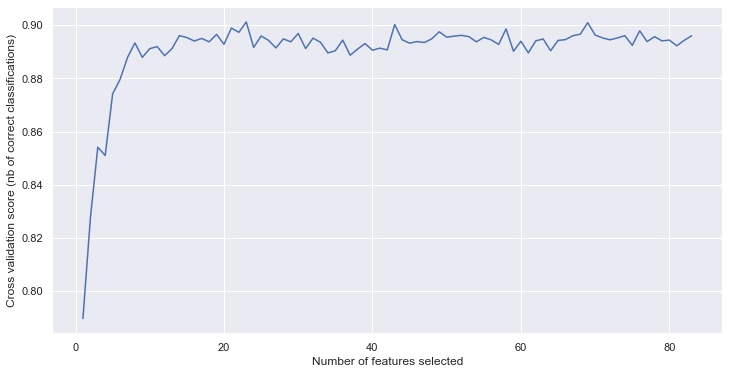

In [131]:
feature_selection_report(classifier_pipeline)

In [4]:
def feature_importance_plot(pipeline):
    selected_features_classifier = col[pipeline['feature_selection'].get_support()]
    importances = pipeline['parameter_tuning'].best_estimator_.feature_importances_

    classifier_features = pd.DataFrame(list(zip(selected_features_classifier, importances)), columns=["Feature", "Weight"]).sort_values(by="Weight", ascending=False)

    plt.figure(figsize=(10,10))
    sns.barplot(x=classifier_features.Weight, y=classifier_features.Feature, orient="h")

    plt.show()

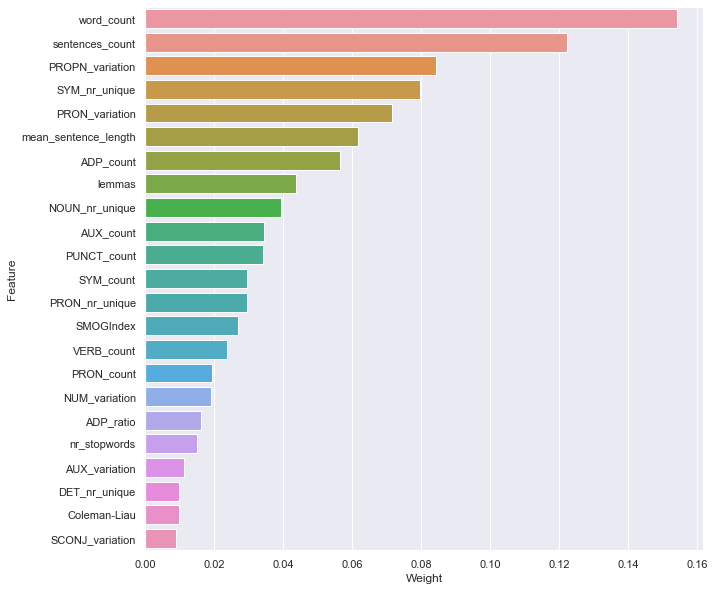

In [207]:
selected_features_classifier = col[classifier_pipeline['feature_selection'].get_support()]
feature_importance_plot(classifier_pipeline)

# Regression model

## Parameter tuning

In [74]:
param_grid = {
    'alpha': [0.1, 0.01, 0.001, 0.2, 0.3, 0.4, 0.5, 0.6, 0.6, 1]
}

## Create pipeline
Just like with the classifier I use the RFECV and RandomizedSearchCV methods. Estimators I have tried: Ridge, Lasso, ElasticNet, LinearRegression, ARDRegression. <br>
Ridge and BayesianRidge perform best.

In [75]:
regression_pipeline = Pipeline([
        ('feature_selection', RFECV(Ridge(), scoring='explained_variance')),
        ('parameter_tuning', RandomizedSearchCV(Ridge(), param_grid, cv=5, scoring='explained_variance'))          
    ])

## Train model and predict test set

In [76]:
regression_pipeline.fit(X_train, y_train['T3F_54'])
regression_y_test_pred = regression_pipeline.predict(X_test)

In [77]:
# These are the best parameters found by the RandomizedSearchCV
print(f"Params: {regression_pipeline['parameter_tuning'].best_params_}")

Params: {'alpha': 0.6}


In [78]:
# Save model
regressor = regression_pipeline['parameter_tuning'].best_estimator_
pickle.dump(regressor, open("models/regression", 'wb'))

In [67]:
# Load model
regressor = pickle.load(open("models/regression", 'rb'))

## Evaluate model

In [94]:
# Function to print different metrics
def regression_evaluation_report(y_test, y_test_pred):
    print(f"explained_variance: {regression_pipeline['parameter_tuning'].best_score_}")
    print(f"mean absolute error: {mean_absolute_error(y_test, y_test_pred)}")
    sns.scatterplot(x = y_test_pred, y = y_test)
    sns.lineplot(x=range(15), y =range(15), color = 'red')
    plt.xlabel("Predicted score")
    plt.ylabel("Actual score")

In [95]:
regression_evaluation_report(y_test['T3F_54'], regression_y_test_pred)

explained_variance: 0.7094624997008583
mean absolute error: 1.4574832348181832


## Selected Features

Optimal number of features : 10


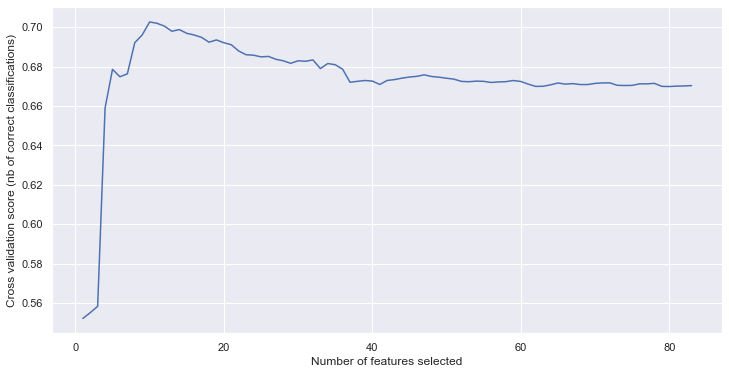

In [190]:
feature_selection_report(regression_pipeline)

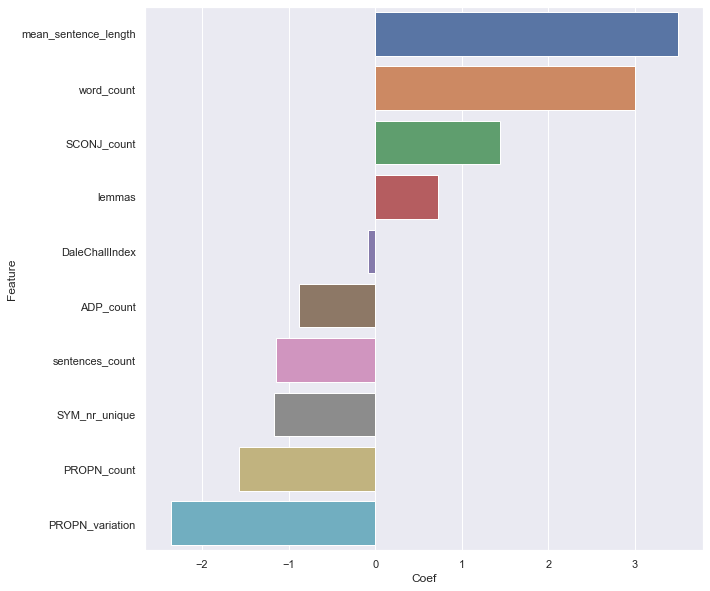

In [201]:
selected_features_regressor = col[regression_pipeline['feature_selection'].get_support()]
importances = regressor.coef_
regressor_features = pd.DataFrame(list(zip(selected_features_regressor, importances)), columns=["Feature", "Coef"]).sort_values(by="Coef", ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(x=regressor_features.Coef, y=regressor_features.Feature, orient="h")

plt.show()

In [211]:
set(list(selected_features_regressor) + list(selected_features_classifier))

{'ADP_count',
 'ADP_ratio',
 'AUX_count',
 'AUX_variation',
 'Coleman-Liau',
 'DET_nr_unique',
 'DaleChallIndex',
 'NOUN_nr_unique',
 'NUM_variation',
 'PRON_count',
 'PRON_nr_unique',
 'PRON_variation',
 'PROPN_count',
 'PROPN_variation',
 'PUNCT_count',
 'SCONJ_count',
 'SCONJ_variation',
 'SMOGIndex',
 'SYM_count',
 'SYM_nr_unique',
 'VERB_count',
 'lemmas',
 'mean_sentence_length',
 'nr_stopwords',
 'sentences_count',
 'word_count'}

# Hybrid model
In this part of the notebook I try out different classifications. It becomes clear from the AUC per class that is it most difficult to predict grades between 6-9, and more specifically grades 6-8. 

In [23]:
from yellowbrick.classifier import ROCAUC

## 3 classes

We can see here that 2's get just as much predicts as 1's as they get predicted as 3's. So far there does not seem to be a bias upwards or downwards.

In [108]:
model = RandomForestClassifier()
model.fit(X_train, y_train['label_3_classes'])
prediction = model.predict(X_test)

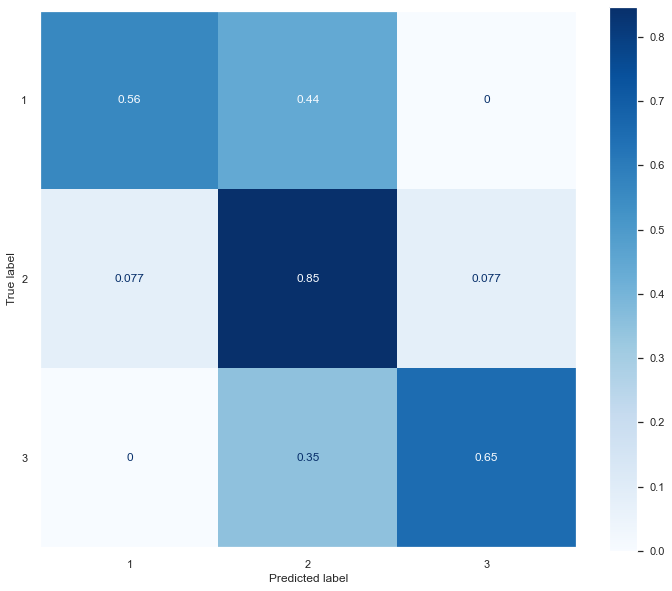

In [109]:
sm.plot_confusion_matrix(model, X_test, y_test['label_3_classes'], labels=[1, 2, 3], cmap=plt.cm.Blues, normalize='true')
plt.grid(False)

In [29]:
visualizer = ROCAUC(model, classes=["0", "1", "2", "3"])

visualizer.fit(X_train, y_train['label_3_classes'])
visualizer.score(X_test, y_test['label_3_classes'])
visualizer.show()

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [110]:
sm.accuracy_score(y_test['label_3_classes'], prediction)

0.7074468085106383

<AxesSubplot:xlabel='T3F_54', ylabel='AUC'>

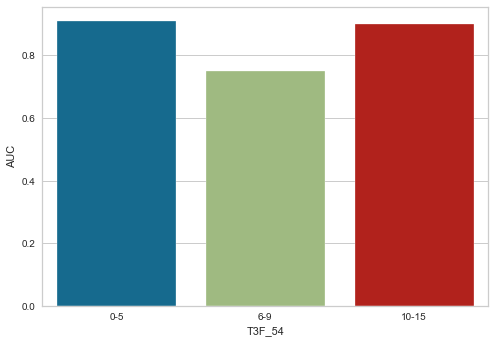

In [235]:
x = ["0-5", "6-9", "10-15"]
y = [0.91, 0.75, 0.90]
auc_df = pd.DataFrame(list(zip(x, y)), columns =['T3F_54', 'AUC'])
sns.barplot(x = auc_df.T3F_54, y = auc_df.AUC)

## 5 classes

Here we can see that the predictions are often too high. This is specifically true for 2 (those get predictes as 3's).

In [111]:
model = RandomForestClassifier()
model.fit(X_train, y_train['label_5_classes'])
prediction = model.predict(X_test)

In [38]:
sm.plot_confusion_matrix(model, X_test, y_test['label_5_classes'], labels=[1, 2, 3, 4, 5], cmap=plt.cm.Blues, normalize='true')
plt.grid(False)

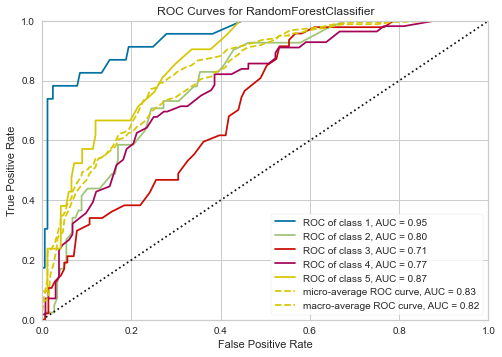

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [37]:
visualizer = ROCAUC(model, classes=["0", "1", "2", "3", "4", "5"])

visualizer.fit(X_train, y_train['label_5_classes'])
visualizer.score(X_test, y_test['label_5_classes'])
visualizer.show()

<AxesSubplot:xlabel='T3F_54', ylabel='AUC'>

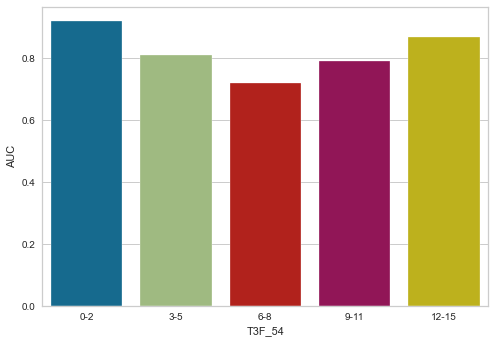

In [236]:
x = ["0-2", "3-5", "6-8", "9-11", "12-15"]
y = [0.92, 0.81, 0.72, 0.79, 0.87]
auc_df = pd.DataFrame(list(zip(x, y)), columns =['T3F_54', 'AUC'])

sns.barplot(x = auc_df.T3F_54, y = auc_df.AUC)

In [112]:
sm.accuracy_score(y_test['label_5_classes'], prediction)

0.48404255319148937

## 16 classes
A classifier with 16 classes is very unlikely to perform well with so little data (test set of 188 rows). It is interesting to see that again it is most easy to predict low grades. Model seems to have most difficulty predicting 9's. (and 14 and 15 but there is too little data for these groups)

In [113]:
model = RandomForestClassifier()
model.fit(X_train, y_train['T3F_54'])
prediction = model.predict(X_test)

In [93]:

print(f"Explained variance: {sm.explained_variance_score(y_test['T3F_54'], prediction)}")
print(f"Mean absolute error: {sm.median_absolute_error(y_test['T3F_54'], prediction)}")

Explained variance: 0.6116029331942656
Mean absolute error: 2.0


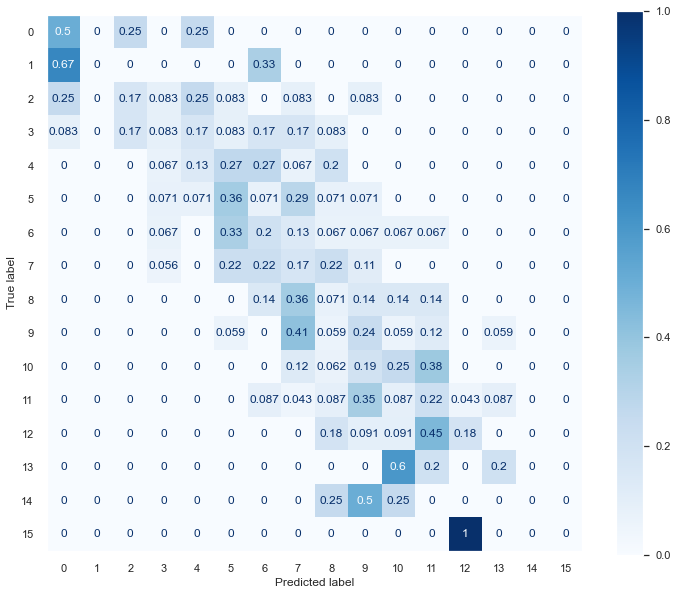

In [63]:
sns.set(rc={'figure.figsize':(12,10)})
sm.plot_confusion_matrix(model, X_test, y_test['T3F_54'], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ,13, 14, 15], cmap=plt.cm.Blues, normalize='true')
plt.grid(False)

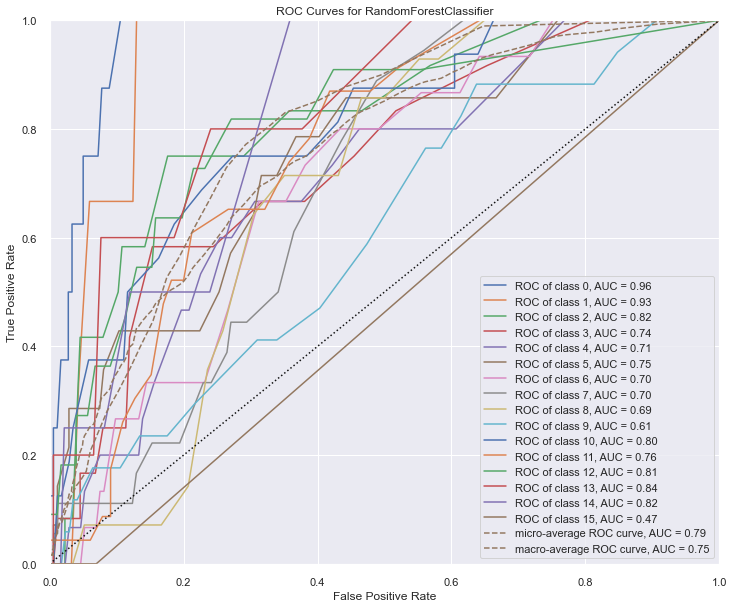

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [64]:
visualizer = ROCAUC(model, classes=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11","12", "13", "14", "15"])

visualizer.fit(X_train, y_train['T3F_54'])
visualizer.score(X_test, y_test['T3F_54'])
visualizer.show()

In [114]:
sm.accuracy_score(y_test['T3F_54'], prediction)

0.20212765957446807

<AxesSubplot:xlabel='Score', ylabel='AUC'>

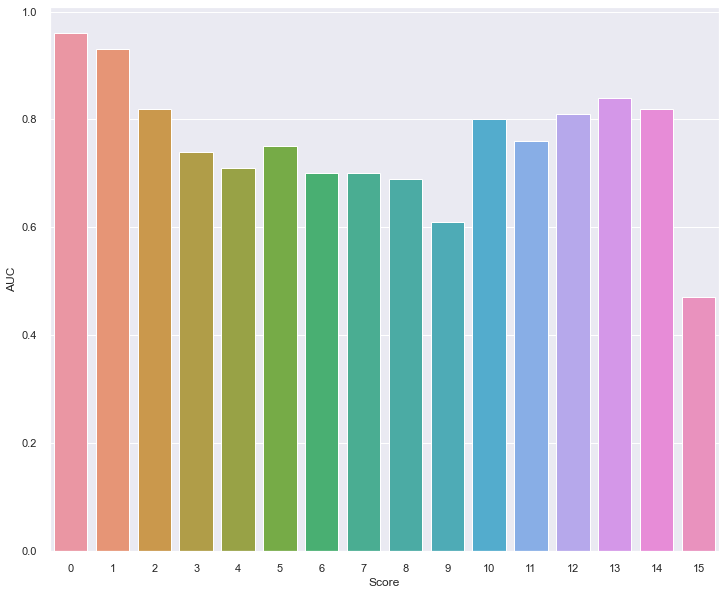

In [65]:
x = list(range(0,16))
y = [0.96, 0.93, 0.82, 0.74, 0.71, 0.75, 0.70, 0.70, 0.69, 0.61, 0.80, 0.76, 0.81, 0.84, 0.82, 0.47]
auc_df = pd.DataFrame(list(zip(x, y)), columns =['Score', 'AUC'])

import seaborn as sns
sns.barplot(x = auc_df.Score, y = auc_df.AUC)